In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import ComplementNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import BorderlineSMOTE, ADASYN
from collections import defaultdict
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import balanced_accuracy_score, classification_report, roc_auc_score
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.classifier import ROCAUC
import warnings
random_state=42

Using TensorFlow backend.
C:\Users\Nafiseh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#data = pd.read_csv("/Users/max/Quick Jupyter Notebooks/MMAI/MMAI 823 - Finance/Bankruptcy_data_Final.csv", header=0)

In [3]:
#data_noNa = data.dropna()
data_noNa = pd.read_csv('data/cleaned_data.csv')

In [4]:
corr = data_noNa.corr()

[Text(0.5, 0, "Tobin's Q"),
 Text(1.5, 0, 'EPS'),
 Text(2.5, 0, 'Liquidity'),
 Text(3.5, 0, 'Profitability'),
 Text(4.5, 0, 'Productivity'),
 Text(5.5, 0, 'Leverage Ratio'),
 Text(6.5, 0, 'Asset Turnover'),
 Text(7.5, 0, 'Operational Margin'),
 Text(8.5, 0, 'Return on Equity'),
 Text(9.5, 0, 'Market Book Ratio'),
 Text(10.5, 0, 'Assets Growth'),
 Text(11.5, 0, 'Sales Growth'),
 Text(12.5, 0, 'Employee Growth'),
 Text(13.5, 0, 'BK')]

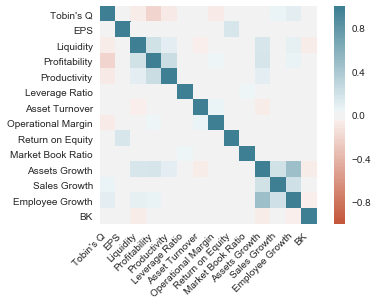

In [5]:
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [6]:
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
scaled_data_noNan = data_noNa.copy()

In [7]:
# Scale values using min/max if there are only positive values, 
# and standard scaler if the minimum value is less than 0 to capture the negative values

# STRIKE THIS: NAIVE BAYS CAN ONLY HAVE NON-NEGATIVE VALUES

for (columnName, columnData) in scaled_data_noNan.iteritems():
    scaled_data_noNan[columnName] = minmax_scaler.fit_transform(columnData.values.reshape(-1,1))

X = scaled_data_noNan.iloc[:, :13]
y = scaled_data_noNan.iloc[:,-1:]
# Stratified Shuffle Split into Train/Test
sss = StratifiedShuffleSplit(test_size=0.2, random_state=random_state)
sss.get_n_splits(X, y)

for train_idx, test_idx in sss.split(X,y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx].values, y.iloc[test_idx].values

In [8]:
# Resampling

resampled = defaultdict()

# SMOTEN-NN
resampler = SMOTEENN(random_state=random_state)
X_rs, y_rs = resampler.fit_resample(X_train,y_train)
X_rs["BK"] = y_rs
resampled['SMOTEENN'] = X_rs

# SMOTE-Tomek
resampler = SMOTETomek(random_state=random_state)
X_rs, y_rs = resampler.fit_resample(X_train,y_train)
X_rs["BK"] = y_rs
resampled['SMOTETomek'] = X_rs

#BorderlineSMOTE
resampler = BorderlineSMOTE(random_state=random_state)
X_rs, y_rs = resampler.fit_resample(X_train,y_train)
X_rs["BK"] = y_rs
resampled['BorderlineSMOTE'] = X_rs

#ADASYN
resampler = ADASYN(random_state=random_state)
X_rs, y_rs = resampler.fit_resample(X_train,y_train)
X_rs["BK"] = y_rs
resampled['ADASYN'] = X_rs


C:\Users\Nafiseh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Nafiseh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Nafiseh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Nafiseh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

## Assumptions
 - Naive Bayes classifiers assume that all predictors have equal effect on the outcome, however we are fairly confident that this is not the case

In [9]:
# corr_normalized = scaled_data_noNan.corr()

# ax = sns.heatmap(
#     corr_normalized, 
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# )

In [10]:
model = ComplementNB()

In [11]:
# Baseline Model - No Sampling

model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Balanced Accuracy Score
rf_score = balanced_accuracy_score(y_test, predictions)
# AUC Score
rf_auc = roc_auc_score(y_test, predictions)

print('Benchmark Balanced Accuracy: ' + str(rf_score))
print('Benchmark AUC Score:' + str(rf_auc))
print(classification_report(y_test, predictions, digits=3))


C:\Users\Nafiseh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Benchmark Balanced Accuracy: 0.7027459442584707
Benchmark AUC Score:0.7027459442584706
              precision    recall  f1-score   support

         0.0      0.997     0.748     0.855     17084
         1.0      0.017     0.658     0.033       111

    accuracy                          0.747     17195
   macro avg      0.507     0.703     0.444     17195
weighted avg      0.991     0.747     0.849     17195



In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix , classification_report, roc_auc_score, f1_score, accuracy_score, cohen_kappa_score, log_loss

def metrics( clf, X_test , y_test):
    
    y_pred = clf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print()
    print(cm)
    print("-----"*5)
    
    print(classification_report(y_test, y_pred))
    print("-----"*5)
    
    y_proba = clf.predict_proba(X_test)
    y_scores = y_proba[:, 1]
    auc = roc_auc_score (y_test, y_scores)
    
    print()
    print(f"ROC AUC score: {auc:.3f}")

    f1 = f1_score(y_test, y_pred)
    print(f"f1 score: {f1:.3f}")
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.3f}")
    
    kappa = cohen_kappa_score(y_test, y_pred)
    print(f"Kappa: {kappa:.3f}".format())
    
    logLoss = log_loss(y_test, y_scores)
    print(f"Log loss: {logLoss:.3f}".format())
    
    metrics = pd.DataFrame({"Accuracy" :[acc], "AUC" : [auc], "f1": [f1], "Kappa": [kappa], "Log Loss": [logLoss]}).round(3)
    return metrics

In [17]:
for set in resampled:
    warnings.filterwarnings("ignore")

    X_train = resampled[set].iloc[:, :13]
    y_train = resampled[set].iloc[:,-1:].values.reshape(-1,1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Balanced Accuracy Score
    rf_score = balanced_accuracy_score(y_test.reshape(-1,1), predictions.reshape(-1,1))
    # AUC Score
    rf_auc = roc_auc_score(y_test.reshape(-1,1), predictions.reshape(-1,1))
    
    print('**************')
    met = metrics( model, X_test , y_test)
    print('**************')
    #rf_cm = confusion_matrix()
    print('Resampled Using ' + str(set))
    print('Benchmark Balanced Accuracy: ' + str(rf_score))
    print('Benchmark AUC Score:' + str(rf_auc))
    print(classification_report(y_test.reshape(-1,1), predictions.reshape(-1,1), digits=3))

**************
Confusion Matrix:

[[12557  4527]
 [   37    74]]
-------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.74      0.85     17084
         1.0       0.02      0.67      0.03       111

    accuracy                           0.73     17195
   macro avg       0.51      0.70      0.44     17195
weighted avg       0.99      0.73      0.84     17195

-------------------------

ROC AUC score: 0.752
f1 score: 0.031
Accuracy: 0.735
Kappa: 0.019
Log loss: 0.685
**************
Resampled Using SMOTEENN
Benchmark Balanced Accuracy: 0.7008409427924764
Benchmark AUC Score:0.7008409427924763
              precision    recall  f1-score   support

         0.0      0.997     0.735     0.846     17084
         1.0      0.016     0.667     0.031       111

    accuracy                          0.735     17195
   macro avg      0.507     0.701     0.439     17195
weighted avg      0.991     0.735     0.841     17195

**************
Conf

In [18]:
X_test.shape


(17195, 13)